## Cosmological constraints on quantum fluctuations in modified teleparallel gravity

The Friedmann equations' modified by quantum fluctuations can be written as
\begin{equation}
3 H^2=\cdots ,
\end{equation}
and
\begin{equation}
2 \dot{H}+3 H^2=\cdots ,
\end{equation}
whereas the modified Klein-Gordon equation can be written in the form
\begin{equation}
\dot{\rho} + 3 H \left( \rho + P \right) = \cdots
\end{equation}
where $H$ is the Hubble function, and $(\rho, P)$ are the fluid energy density and pressure. Dots over a variable denote differentiation with respect to the cosmic time $t$. The ellipses on the right hand sides represent the quantum corrections. See [arXiv:2108.04853](https://arxiv.org/abs/2108.04853) and [arXiv:2111.11761](https://arxiv.org/abs/2111.11761) for full details.

This jupyter notebook is devoted to constraining the quantum corrections using late-time compiled data sets from cosmic chronometers (CC), supernovae (SNe), and baryon acoustic oscillations (BAO). In other words, we shall be numerically integrate the dynamical system and perform a Bayesian analysis to determine a best fit theory parameters. We divide the discussion in three sections: (1) observation, (2) theory, and (3) data analysis.

*References to the data and python packages can be found at the end of the notebook.*

In [1]:
import numpy as np
from scipy.integrate import solve_ivp, simps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # for the insets
from scipy.constants import c

from cobaya.run import run
from getdist.mcsamples import loadMCSamples
from gdplotter_rcb import plot_triangle, plot_1d
import os # requires *full path*

# for imposing likelihood time limit; otherwise, mcmc gets stuck
from multiprocessing import Process

### 1. Observation

We import the cosmological data to be used for constraining the theory. We start with the CC + BAO which provides measurements of the Hubble function at various redshifts.

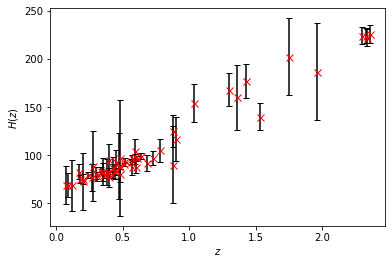

In [3]:
cc_data = np.loadtxt('Hdz_2020.txt')

z_cc = cc_data[:, 0]
Hz_cc = cc_data[:, 1]
sigHz_cc = cc_data[:, 2]

fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc,
            fmt = 'rx', ecolor = 'k',
            markersize = 7, capsize = 3)
ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
plt.show()

We also consider the 1048 supernovae observations in the form of the Pantheon compilation.

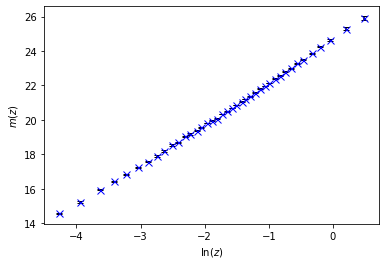

In [4]:
# load pantheon compressed m(z) data
loc_lcparam = 'https://raw.githubusercontent.com/dscolnic/Pantheon/master/Binned_data/lcparam_DS17f.txt'
loc_lcparam_sys = 'https://raw.githubusercontent.com/dscolnic/Pantheon/master/Binned_data/sys_DS17f.txt'
#loc_lcparam = 'https://raw.githubusercontent.com/dscolnic/Pantheon/master/lcparam_full_long_zhel.txt'
#loc_lcparam_sys = 'https://raw.githubusercontent.com/dscolnic/Pantheon/master/sys_full_long.txt'
lcparam = np.loadtxt(loc_lcparam, usecols = (1, 4, 5))
lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)

# setup pantheon samples
z_ps = lcparam[:, 0]
logz_ps = np.log(z_ps)
mz_ps = lcparam[:, 1]
sigmz_ps = lcparam[:, 2]

# pantheon samples systematics
covmz_ps_sys = lcparam_sys.reshape(40, 40)
#covmz_ps_sys = lcparam_sys.reshape(1048, 1048)
covmz_ps_tot = covmz_ps_sys + np.diag(sigmz_ps**2)

# plot data set
plt.errorbar(logz_ps, mz_ps, yerr = np.sqrt(np.diag(covmz_ps_tot)),
             fmt = 'bx', markersize = 7, ecolor = 'k', capsize = 3)
plt.xlabel('$\ln(z)$')
plt.ylabel('$m(z)$')
plt.show()

The compiled CC, SNe, and BAO data sets above will be used to constrain the quantum corrections arising as teleparallel gravity terms in the Friedmann equations.

### 2. Theory

We setup the Hubble function $H(z)$ by numerically integrating the field equations. This is in preparation for analysis later on where this observable as well as the supernovae apparent magnitudes are compared with the data.

We start by coding the differential equation (in the form $y'(z) = f[y(z),z]$) and the density parameters and other relevant quantities in the next line.

In [4]:
def F(z, y, om0, eps):
    '''returns the differential equation y' = f(y, z) for input to odeint
    input: y = H(z)/H0
           z = redshift
           om0 = matter fraction at z = 0
           eps = LambdaCDM deviation'''
    lmd = 1 - om0 + eps
    q = -(-1 + lmd + om0)/(6*(-6 + 4*lmd - om0))
    
    num = 3*(-lmd + (1 - 24*q*lmd)*(y**2) + 36*q*(y**4)) \
          *(1 + 18*q*(y**2)*(-1 + 4*q*(y**2)))
    den = 2*(1 + z)*y*(1 - 18*q*lmd \
                       + 6*q*(y**2)*(7 + 126*q*lmd \
                                     + 24*q*(y**2)*(-13 - 12*q*lmd + 45*q*(y**2))))
    return num/den

def ol0(om0, eps):
    '''returns the density parameter of lambda'''
    return 1 - om0 + eps

def q_param(om0, eps):
    '''returns the dimensionless quantum correction parameter'''
    lmd = 1 - om0 + eps
    q = -(-1 + lmd + om0)/(6*(-6 + 4*lmd - om0))
    return q

def oq0(om0, eps):
    '''returns the density parameter of the quantum corrections'''
    lmd = 1 - om0 + eps
    q = -(-1 + lmd + om0)/(6*(-6 + 4*lmd - om0))
    return q*(24*lmd - 6*(6 + lmd))

Now that the equations are all set, we can proceed with the numerical integration. We test this out in the next line.

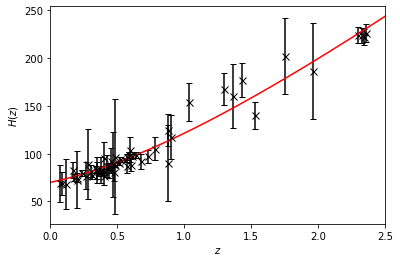

In [5]:
# late-time redshifts
z_min = 0
z_max = 2.5
n_div = 12500
z_late = np.linspace(z_min, z_max, n_div)

def nsol(om0, eps):
    '''numerically integrates the master ode
    returns: y(z) = H(z)/H0: rescaled Hubble function'''
    nsol = solve_ivp(F, t_span = (z_min, z_max), y0 = [1], t_eval = z_late, args = (om0, eps))
    return nsol

# pilot/test run, shown with the CC data
test_run = nsol(om0 = 0.3, eps = 0.01)

fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc,
            fmt = 'kx', ecolor = 'k',
            markersize = 7, capsize = 3)
ax.plot(test_run.t, 70*test_run.y[0], 'r-')
ax.set_xlim(z_min, z_max)
ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
plt.show()

We also setup the integral to obtain the SNe apparent magnitude. We assume a spatially-flat scenario in which the luminosity distance given by
\begin{equation}
d_L \left( z \right) = \dfrac{c}{H_0} \left( 1 + z \right) \int_0^z \dfrac{dz'}{H\left(z'\right) /H_0} .
\end{equation}

*$H_0$ will be written as $h \times 100$ (km/s/Mpc) $= h \times 10^{-1}$ (m/s/pc). The factor $c/H_0$ will then be written as $c / \left(h \times 10^{-1}\right)$ parsecs where $c$ is the speed of light in vacuum in m/s (a.k.a. scipy value).

In [6]:
def dl(om0, eps, z_rec):
    '''returns the luminosity distance
    input: z_rec = redshifts at prediction'''
    E_sol = nsol(om0, eps).y[0]
    E_inv = 1/E_sol
    dL = []
    for z_i in z_rec:
        diff_list = list(abs(z_i - z_late))
        idx = diff_list.index(min(diff_list))
        dL.append((1 + z_i)*simps(E_inv[:idx + 1], z_late[:idx + 1]))
    return np.array(dL)

def dm(H0, om0, eps, z_rec):
    '''returns the distance modulus m - M
    input: z_rec = redshifts at prediction'''
    h = H0/100
    return 5*np.log10((c/h)*dl(om0, eps, z_rec))

def m0(H0, om0, eps, M, z_rec):
    '''returns the apparent magnitude m
    input: z_rec = redshifts at prediction'''
    return dm(H0, om0, eps, z_rec) + M

We can test out a prediction with the Pantheon data set. Here is an illustration for the same parameters used in the CC prediction earlier.

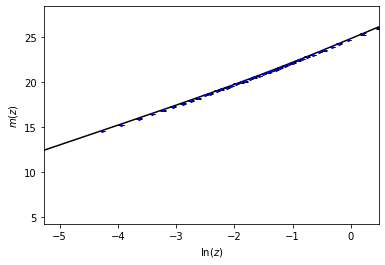

In [7]:
test_run = m0(H0 = 70, om0 = 0.3, eps = 0.01,
              M = -19.3, z_rec = z_late[1:])

fig, ax = plt.subplots()
ax.plot(np.log(z_late[1:]), test_run, 'k-')
ax.errorbar(logz_ps, mz_ps, yerr = np.sqrt(np.diag(covmz_ps_tot)),
            fmt = 'bo', markersize = 2, ecolor = 'k', capsize = 3)
ax.set_xlim(min(logz_ps) - 1, max(logz_ps))
ax.set_xlabel('$\ln(z)$')
ax.set_ylabel('$m(z)$')
plt.show()

With predictions of $H(z)$ and $m(z)$, we're now ready to study the data with the model.

### 3. Data analysis

We setup the individual and joint log-likelihoods for the CC, SNe, and BAO data sets.

In [8]:
def loglike_cc_bao(H0, om0, eps):
    '''returns the log-likelihood for the CC data'''
    if (om0 < 0) or (np.abs(oq0(om0, eps)) > 0.1):
        return -np.inf
    else:
        H_sol = H0*nsol(om0, eps).y[0]
        H_sol_cc = []    
        for z_i in z_cc:
            diff_list = list(abs(z_i - z_late))
            idx = diff_list.index(min(diff_list))
            H_sol_cc.append(H_sol[idx])
        H_sol_cc = np.array(H_sol_cc)
        Delta_H = H_sol_cc - Hz_cc
        ll_cc = -0.5*np.sum((Delta_H/sigHz_cc)**2)
        if np.isnan(ll_cc) == True:
            return -np.inf
        else:
            return ll_cc
        
C_inv = np.linalg.inv(covmz_ps_tot)

def loglike_sn(H0, om0, eps, M):
    '''returns the log-likelihood for the SN data'''
    if (om0 < 0) or (np.abs(oq0(om0, eps)) > 0.1):
        return -np.inf
    else:
        m_sol_ps = m0(H0, om0, eps, M, z_ps)
        Delta_m = m_sol_ps - mz_ps
        ll_sn = -0.5*(Delta_m.T @ C_inv @ Delta_m)
        if np.isnan(ll_sn) == True:
            return -np.inf
        else:
            return ll_sn
        
def loglike_cc_bao_sn(H0, om0, eps, M):
    '''returns the total CC + BAO + SNe likelihood for a theory prediction'''
    return loglike_cc_bao(H0, om0, eps) + loglike_sn(H0, om0, eps, M)

Now, we must impose a time limit to the evaluation of the likelihood. Otherwise, the MCMC would not converge particularly when using MPI as some of the chains get stuck in certain, isolated regions of the parameter space.

In [9]:
# impose timeout, to avoid evaluations/chains getting stuck somewhere
def Loglike_cc_bao(H0, om0, eps):
    '''same loglike but with timelimit of 10 secs per eval'''
    p = Process(target = loglike_cc_bao, args = (H0, om0, eps,))
    p.start()
    p.join(10)
    if p.is_alive():
        p.terminate()
        p.join()
        return -np.inf
    else:
        return loglike_cc_bao(H0, om0, eps)

def Loglike_cc_bao_sn(H0, om0, eps, M):
    '''same loglike but with timelimit of 10 secs per eval'''
    p = Process(target = loglike_cc_bao_sn, args = (H0, om0, eps, M,))
    p.start()
    p.join(10)
    if p.is_alive():
        p.terminate()
        p.join()
        return -np.inf
    else:
        return loglike_cc_bao_sn(H0, om0, eps, M)

The input to ``cobaya`` is preferrably prepared as a ``.yaml`` file to run in a cluster. See the ones in the directory. This comprises of the likelihood and the priors to be used for the sampling.

Nonetheless, if one insists, the input can also be prepared as a python dictionary. We show an example below.

In [ ]:
# SNe Mag prior, SH0ES taken from lit., cepheids calibrated
M_priors = {'SH0ES': {'ave': -19.22, 'std': 0.04}}
M_prior = M_priors['SH0ES']

# likelihood
#info = {"likelihood": {"loglike": Loglike_cc_bao}}
info = {"likelihood": {"loglike": Loglike_cc_bao_sn}}

# parameters to perform mcmc
info["params"] = {"H0": {"prior": {"min": 50, "max": 80},
                         "ref": {"min": 68, "max": 72},
                         "proposal": 0.05, "latex": r"H_0"},
                  "om0": {"prior": {"min": 0, "max": 1},
                          "ref": {"min": 0.25, "max": 0.35},
                          "proposal": 1e-3, "latex": r"\Omega_{m0}"},
                  "eps": {"prior": {"min": -1e-1, "max": 1e-1},
                          "ref": {"min": -1e-2, "max": 1e-2},
                          "proposal": 1e-3, "latex": r"\epsilon"}}

# uncomment info["params"]["M"] if SNe data is considered
info["params"]["M"] = {"prior": {"dist": "norm",
                                 "loc": M_prior['ave'],
                                 "scale": M_prior['std']},
                       "ref": M_prior['ave'],
                       "proposal": M_prior['std']/4, "latex": r"M"}

info["params"]["q"] = {"derived": q_param, "latex": r"q"}
info["params"]["ol0"] = {"derived": ol0, "latex": r"\Omega_{\Lambda}"}
info["params"]["oq0"] = {"derived": oq0, "latex": r"\Omega_{q0}"}

# mcmc, Rminus1_stop dictates covergence
info["sampler"] = {"mcmc":{"Rminus1_stop": 0.01, "max_tries": 1000}}

# output, uncomment to save output in the folder chains
#info["output"] = "chains_nonminmat_Hdz_Pantheon/tg_quantum_M_SH0ES_cc_bao"
info["output"] = "chains_nonminmat_Hdz_Pantheon/tg_quantum_M_SH0ES_cc_bao_sn"

# uncomment to overwrite existing files, be careful
#info["force"] = True

The sampling can now be performed. Suggestion is to run this in a cluster using the command ``cobaya-run``, e.g., with $N$ processes: ``mpirun -n N cobaya-run -f __.yaml``. See also the sample yaml file in the same directory as this jupyter notebook.

In a python interpreter, the MCMC can be performed using the function ``run``. Example below.

The results of the sampling can be viewed any time once the results are saved. We prepare the plots by defining the following generic plotting functions using ``getdist`` in ``gdplotter_rcb.py``. The posteriors for the density parameters provided the (1) CC + SNe and (2) CC + SNe + BAO data sets are shown below.

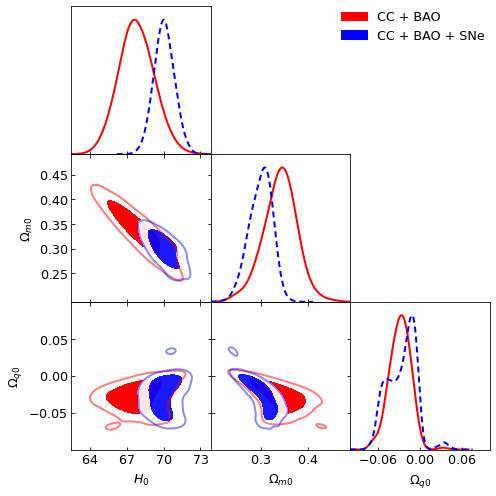

In [12]:
# specify file location(s)
folder_filename_0 = "chains_nonminmat_Hdz_Pantheon/tg_quantum_cc_bao"
folder_filename_1 = "chains_nonminmat_Hdz_Pantheon/tg_quantum_M_SH0ES_cc_bao_sn"

# loading results from folder_filename
gdsamples_0 = loadMCSamples(os.path.abspath(folder_filename_0))
gdsamples_1 = loadMCSamples(os.path.abspath(folder_filename_1))

plot_triangle([gdsamples_0, gdsamples_1],
              ["H0", "om0", "oq0"],
              ['red', 'blue'],
              ['-', '--'],
              [r"CC + BAO",
               r"CC + BAO + SNe"],
              thickness = 3, font_size = 15, title_fs = 15,
              parlims = {'oq0': (-0.1, 0.1)}, lgd_font_size = 15)

This shows a slight preference for quantum corrections ($\Omega_{q0} < 0$). We shall look at the statistical significance of this later.

Here is the corresponding plot for the other parameters.

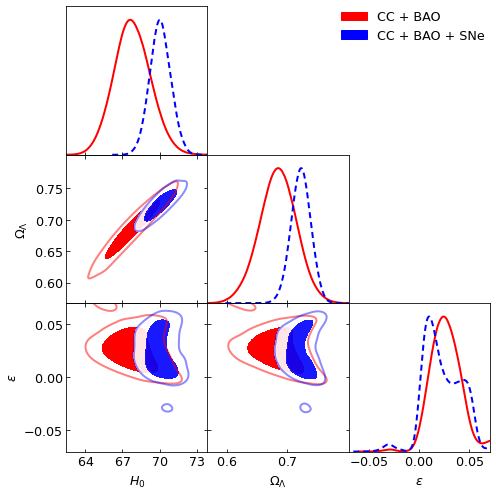

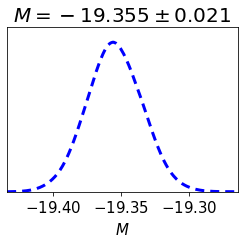

In [13]:
plot_triangle([gdsamples_0, gdsamples_1],
              ["H0", "ol0", "eps"],
              ['red', 'blue'],
              ['-', '--'],
              [r"CC + BAO",
               r"CC + BAO + SNe"],
              thickness = 3, font_size = 15, title_fs = 15,
              parlims = {'eps': (-0.07, 0.07)}, lgd_font_size = 15)

plot_1d([gdsamples_1], ["M"], clrs = ['blue'], thickness = 3,
        lsty = ['--'], font_size = 15, width_inch = 3.5, figs_per_row = 1)

It is also useful to look at the posteriors with the corresponding $\Lambda$CDM model ($\varepsilon = 0$). 

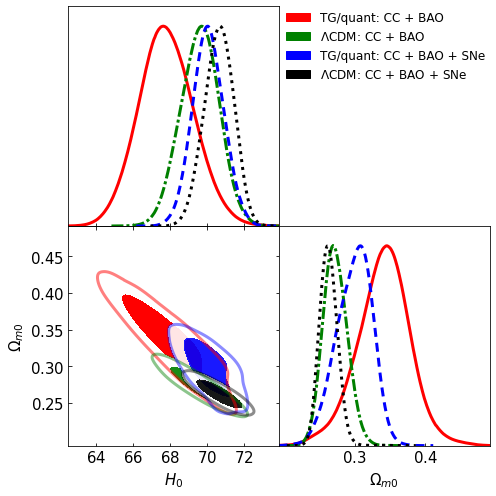

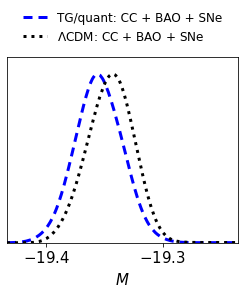

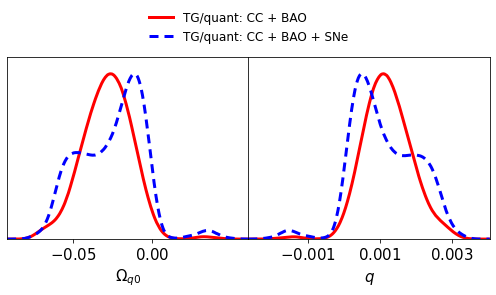

In [14]:
# specify file location(s)
folder_filename_2 = "chains_lcdm_Hdz_Pantheon/lcdm_cc_bao"
folder_filename_3 = "chains_lcdm_Hdz_Pantheon/lcdm_M_SH0ES_cc_bao_sn"

# loading results from folder_filename
gdsamples_2 = loadMCSamples(os.path.abspath(folder_filename_2))
gdsamples_3 = loadMCSamples(os.path.abspath(folder_filename_3))

plot_triangle([gdsamples_0, gdsamples_2, gdsamples_1, gdsamples_3],
              ["H0", "om0"],
              ['red', 'green', 'blue', 'black'],
              ['-', '-.', '--', ':'],
              [r"TG/quant: CC + BAO",
               r"$\Lambda$CDM: CC + BAO",
               r"TG/quant: CC + BAO + SNe",
               r"$\Lambda$CDM: CC + BAO + SNe"],
              thickness = 3, font_size = 15, title_fs = 15,
              width_inch = 7, lgd_font_size = 12)

plot_1d([gdsamples_1, gdsamples_3], ["M"],
        lbls = [r"TG/quant: CC + BAO + SNe",
                r"$\Lambda$CDM: CC + BAO + SNe"],
        clrs = ['blue', 'black'],
        lsty = ['--', ':'], thickness = 3,
        font_size = 15, lgd_font_size = 12,
        width_inch = 3.5, figs_per_row = 1)

plot_1d([gdsamples_0, gdsamples_1], ["oq0", "q"],
        lbls = [r"TG/quant: CC + BAO",
                r"TG/quant: CC + BAO + SNe"],
        clrs = ['red', 'blue'],
        lsty = ['-', '--'], thickness = 3,
        font_size = 15, lgd_font_size = 12,
        width_inch = 7, figs_per_row = 2)

We can obtain the best estimates (marginalized statistics) of the constrained parameters $H_0$, $\Omega_{m0}$, $\Omega_\Lambda$, $\Omega_{q0}$, $\varepsilon$, and $M$ (SN absolute magnitude).

In [15]:
# uncomment next 3 lines to get more info on gdsamples_X
#print(gdsamples_x.getGelmanRubin())
#print(gdsamples_x.getConvergeTests())
#print(gdsamples_x.getLikeStats())

def get_bes(gdx, params_list):
    '''get summary statistics for params_list and gdx,
    params_list = list of parameter strings, e.g., ["H0", "om0"]
    gdx = cobaya/getdist samples, e.g., gdsamples_1'''
    
    stats = gdx.getMargeStats()
    
    for p in params_list:
        p_ave = stats.parWithName(p).mean
        p_std = stats.parWithName(p).err
        print()
        print(p, '=', p_ave, '+/-', p_std)

def get_loglike_cc_bao(gdx):
    '''returns the loglikelihood at the mean of the best fit'''
    
    stats = gdx.getMargeStats()
    
    return Loglike_cc_bao(stats.parWithName("H0").mean,
                          stats.parWithName("om0").mean,
                          stats.parWithName("eps").mean)

def get_loglike_cc_bao_sn(gdx):
    '''returns the loglikelihood at the mean of the best fit'''
    
    stats = gdx.getMargeStats()
    
    return Loglike_cc_bao_sn(stats.parWithName("H0").mean,
                             stats.parWithName("om0").mean,
                             stats.parWithName("eps").mean,
                             stats.parWithName("M").mean)
        
print('CC + BAO       : loglike = ', get_loglike_cc_bao(gdsamples_0))
get_bes(gdsamples_0, ["H0", "om0", "ol0", "oq0", "eps", "q"])
print()
print('CC + SNe + BAO : loglike = ', get_loglike_cc_bao_sn(gdsamples_1))
get_bes(gdsamples_1, ["H0", "om0", "ol0", "oq0", "eps", "q", "M"])

CC + BAO       : loglike =  -14.390450724779976

H0 = 67.8004534543283 +/- 1.4770558775736187

om0 = 0.34080578948060447 +/- 0.03776932283936424

ol0 = 0.6852167726443292 +/- 0.031097649142164077

oq0 = -0.028386252082125873 +/- 0.01623081432927593

eps = 0.026022562079968937 +/- 0.014889691748570664

q = 0.0011964420976620595 +/- 0.0006889664003658708

CC + SNe + BAO : loglike =  -36.76284425721016

H0 = 70.05454742388778 +/- 0.8527931592535787

om0 = 0.2991032108061891 +/- 0.025414395633843102

ol0 = 0.7235945176419945 +/- 0.016742957793318802

oq0 = -0.025412627377857364 +/- 0.020899602813229563

eps = 0.02269772841245066 +/- 0.01862145927771875

q = 0.001106075763625953 +/- 0.0009143510073116634

M = -19.354843877575284 +/- 0.020811981993327823


We end the notebook by comparing the best fit results compared with $\Lambda$CDM. We also print out the $\chi^2$ statistics for the SNe + CC + BAO results.

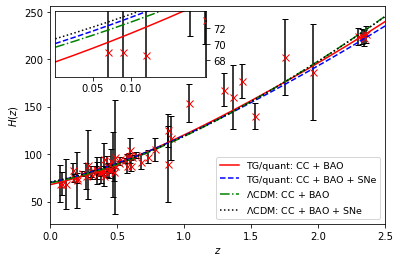

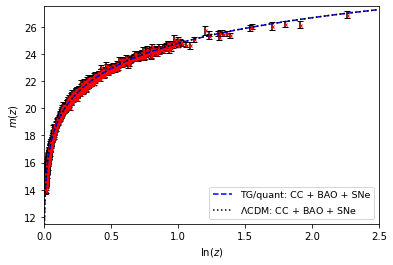

In [16]:
# generic plotting function
def plot_best_fit_Hdz(gdxs, lbls, lsts, gdxs_lcdm, lbls_lcdm, lsts_lcdm,
                      save = False, fname = None, folder = None):
    '''plots the best fit CC results with compared with LambdaCDM'''
    
    # cosmic chronometers
    fig, ax = plt.subplots()
    ix = inset_axes(ax, width = '45%', height = '30%', loc = 'upper left')
    ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'rx',
                ecolor = 'k', markersize = 7, capsize = 3, zorder = 0)
    ix.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'rx',
                ecolor = 'k', markersize = 7, capsize = 3, zorder = 0)
    for i in np.arange(0, len(gdxs)):
        stats = gdxs[i].getMargeStats()
        H0 = stats.parWithName("H0").mean
        om0 = stats.parWithName("om0").mean
        eps = stats.parWithName("eps").mean
        Hz = H0*nsol(om0 = om0, eps = eps).y[0]
        ax.plot(z_late, Hz, lsts[i], label = lbls[i])
        ix.plot(z_late, Hz, lsts[i])
    for i in np.arange(0, len(gdxs_lcdm)):
        stats = gdxs_lcdm[i].getMargeStats()
        H0 = stats.parWithName("H0").mean
        om0 = stats.parWithName("om0").mean
        Hz = H0*nsol(om0 = om0, eps = 0).y[0]
        ax.plot(z_late, Hz, lsts_lcdm[i], label = lbls_lcdm[i])
        ix.plot(z_late, Hz, lsts_lcdm[i])
    ax.set_xlim(z_min, z_max)
    ax.set_xlabel('$z$')
    ax.set_ylabel('$H(z)$')
    ax.legend(loc = 'lower right', prop = {'size': 9.5})
    ix.set_xlim(0, 0.2)
    ix.set_ylim(66, 74)
    ix.set_xticks([0.05, 0.1])
    ix.yaxis.tick_right()
    ix.set_yticks([68, 70, 72])
    ix.xaxis.set_tick_params(labelsize = 10)
    ix.yaxis.set_tick_params(labelsize = 10)
    if save == True:
        fig.savefig(folder + '/' + fname + '.' + fig_format)
        
def plot_best_fit_sne(gdxs, lbls, lsts, \
                      gdxs_lcdm, lbls_lcdm, lsts_lcdm,
                      save = False, fname = None, folder = None):
    '''plots the best fit CC results with compared with LambdaCDM'''
    
    # setup full pantheon samples
    lcparam_full = np.loadtxt('../../datasets/pantheon/lcparam_full_long_zhel.txt',
                              usecols = (1, 4, 5))
    lcparam_sys_full = np.loadtxt('../../datasets/pantheon/sys_full_long.txt',
                                  skiprows = 1)
    z_ps = lcparam_full[:, 0]
    mz_ps = lcparam_full[:, 1]
    sigmz_ps = lcparam_full[:, 2]
    covmz_ps_sys = lcparam_sys_full.reshape(1048, 1048)
    covmz_ps_tot = covmz_ps_sys + np.diag(sigmz_ps**2)
    
    # supernovae
    z_sne = np.logspace(-3, np.log10(2.5), 100)
    fig, ax = plt.subplots()
    ax.errorbar(z_ps, mz_ps, yerr = np.sqrt(np.diag(covmz_ps_tot)),
                fmt = 'rx', markersize = 3, ecolor = 'k', capsize = 3, zorder = 0)
    for i in np.arange(0, len(gdxs)):
        stats = gdxs[i].getMargeStats()
        H0 = stats.parWithName("H0").mean
        om0 = stats.parWithName("om0").mean
        eps = stats.parWithName("eps").mean
        M = stats.parWithName("M").mean
        mz = m0(H0 = H0, om0 = om0, eps = eps, M = M, z_rec = z_sne)
        ax.plot(z_sne, mz, lsts[i], label = lbls[i])
    for i in np.arange(0, len(gdxs_lcdm)):
        stats = gdxs_lcdm[i].getMargeStats()
        H0 = stats.parWithName("H0").mean
        om0 = stats.parWithName("om0").mean
        M = stats.parWithName("M").mean
        mz = m0(H0 = H0, om0 = om0, eps = 0, M = M, z_rec = z_sne)
        ax.plot(z_sne, mz, lsts_lcdm[i], label = lbls_lcdm[i])
    ax.set_xlim(0, 2.5)
    ax.set_ylim(11.5, 27.5)
    ax.set_xlabel('$\ln(z)$')
    ax.set_ylabel('$m(z)$')
    ax.legend(loc = 'lower right', prop = {'size': 9.5})
    if save == True:
        fig.savefig(folder + '/' + fname + '.' + fig_format)
    
plot_best_fit_Hdz([gdsamples_0, gdsamples_1],
                  ['TG/quant: CC + BAO', 'TG/quant: CC + BAO + SNe'],
                  ['r-', 'b--'],
                  [gdsamples_2, gdsamples_3],
                  [r'$\Lambda$CDM: CC + BAO', r'$\Lambda$CDM: CC + BAO + SNe'],
                  ['g-.', 'k:'])

plot_best_fit_sne([gdsamples_1],
                  ['TG/quant: CC + BAO + SNe'],
                  ['b--'],
                  [gdsamples_3],
                  [r'$\Lambda$CDM: CC + BAO + SNe'],
                  ['k:'])

To objectively assess whether the results are significant, we calculate three statistical measures: the $\chi^2$, the Akaike information criterion (AIC), and the Bayesian information criterion (BIC). We can easily compute the chi-squared from the loglikelihood as $\chi^2 = -2 \log \mathcal{L}$. Doing so leads to $\Delta \chi^2 = \chi^2_{\Lambda \text{CDM}} - \chi^2_{\text{TG}}$:

In [17]:
def get_bfloglike_cc_bao(gdx):
    '''returns the best fit loglikelihood using like stats'''
    
    stats = gdx.getLikeStats()
    
    return Loglike_cc_bao(stats.parWithName("H0").bestfit_sample,
                          stats.parWithName("om0").bestfit_sample,
                          stats.parWithName("eps").bestfit_sample)

def get_bfloglike_cc_bao_sn(gdx):
    '''returns the best fit loglikelihood using like stats'''
    
    stats = gdx.getLikeStats()
    
    return Loglike_cc_bao_sn(stats.parWithName("H0").bestfit_sample,
                             stats.parWithName("om0").bestfit_sample,
                             stats.parWithName("eps").bestfit_sample,
                             stats.parWithName("M").bestfit_sample)

# LambdaCDM CC + BAO like-stats
stats_lcdm_cc_bao = gdsamples_2.getLikeStats()
H0_lcdm_cc_bao = stats_lcdm_cc_bao.parWithName("H0").bestfit_sample
om0_lcdm_cc_bao = stats_lcdm_cc_bao.parWithName("om0").bestfit_sample
loglike_lcdm_cc_bao = Loglike_cc_bao(H0_lcdm_cc_bao, om0_lcdm_cc_bao, eps = 0)

# LambdaCDM CC + BAO + SNe like-stats
stats_lcdm_cc_bao_sn = gdsamples_3.getLikeStats()
H0_lcdm_cc_bao_sn = stats_lcdm_cc_bao_sn.parWithName("H0").bestfit_sample
om0_lcdm_cc_bao_sn = stats_lcdm_cc_bao_sn.parWithName("om0").bestfit_sample
M_lcdm_cc_bao_sn = stats_lcdm_cc_bao_sn.parWithName("M").bestfit_sample
loglike_lcdm_cc_bao_sn = Loglike_cc_bao_sn(H0_lcdm_cc_bao_sn, om0_lcdm_cc_bao_sn, \
                                           eps = 0, M = M_lcdm_cc_bao_sn)

print('CC + BAO results')
print('LambdaCDM : chi-squared = ', -2*loglike_lcdm_cc_bao)
print('TG/quant  : chi-squared = ', -2*get_bfloglike_cc_bao(gdsamples_0))
print('Delta chi-squared = ', \
      -2*(loglike_lcdm_cc_bao - get_bfloglike_cc_bao(gdsamples_0)))
print()
print('CC + BAO + SNe results')
print('LambdaCDM : chi-squared = ', -2*loglike_lcdm_cc_bao_sn)
print('TG/quant  : chi-squared = ', -2*get_bfloglike_cc_bao_sn(gdsamples_1))
print('Delta chi-squared = ', \
      -2*(loglike_lcdm_cc_bao_sn - get_bfloglike_cc_bao_sn(gdsamples_1)))

CC + BAO results
LambdaCDM : chi-squared =  32.075673520122784
TG/quant  : chi-squared =  28.618737106195127
Delta chi-squared =  3.4569364139276573

CC + BAO + SNe results
LambdaCDM : chi-squared =  75.24897103548676
TG/quant  : chi-squared =  68.92102582823969
Delta chi-squared =  6.327945207247069


This shows that in both cases $\chi^2 > 0$ which corresponds a (very) slight preference for the inclusion of the quantum corrections. Moving on, the AIC can be computed using
\begin{equation}
\text{AIC} = 2 k - 2 \log(\mathcal{L})
\end{equation}
where $\log(\mathcal{L})$ is the log-likelihood and $k$ is the number of parameters estimated by the model. The results for the AIC are printed in the next line with $\Delta \text{AIC} = \text{AIC}_{\Lambda\text{CDM}} - \text{AIC}_{\text{TG}}$.

In [18]:
print('CC + BAO results')
aic_lcdm_cc_bao = 2*2 - 2*loglike_lcdm_cc_bao # estimated H0, om0
aic_tg_quantum_cc_bao = 2*3 - 2*get_bfloglike_cc_bao(gdsamples_0) # estimated H0, om0, eps
print('LambdaCDM : AIC = ', aic_lcdm_cc_bao)
print('TG/quant  : AIC = ', aic_tg_quantum_cc_bao)
print('Delta AIC = ', \
      aic_lcdm_cc_bao - aic_tg_quantum_cc_bao)
print()
aic_lcdm_cc_bao_sn = 2*3 - 2*loglike_lcdm_cc_bao_sn # estimated ... + M
aic_tg_quantum_cc_bao_sn = 2*4 - 2*get_bfloglike_cc_bao_sn(gdsamples_1)
print('CC + BAO + SNe results')
print('LambdaCDM : AIC = ', aic_lcdm_cc_bao_sn)
print('TGquantum : AIC = ', aic_tg_quantum_cc_bao_sn)
print('Delta AIC = ', \
      aic_lcdm_cc_bao_sn - aic_tg_quantum_cc_bao_sn)

CC + BAO results
LambdaCDM : AIC =  36.075673520122784
TG/quant  : AIC =  34.61873710619513
Delta AIC =  1.4569364139276573

CC + BAO + SNe results
LambdaCDM : AIC =  81.24897103548676
TGquantum : AIC =  76.92102582823969
Delta AIC =  4.327945207247069


In the first case (CC + BAO), the inclusion of the TG/quantum corrections is preferred by the AIC as $\Delta \text{AIC} > 0$; on the other hand, with CC + BAO + SNe, the $\Lambda$CDM is slightly preferred.

The BIC can be computed using
\begin{equation}
\text{BIC} = k \log(n) - 2 \log(\mathcal{L})
\end{equation}
where $\log(\mathcal{L})$ is the log-likelihood, $n$ is the number of data points, and $k$ is the number of parameters estimated by the model. We can again easily compute this together with $\Delta \text{BIC} = \text{BIC}_{\Lambda\text{CDM}} - \text{BIC}_{\text{TG}}$. The results are printed below.

In [19]:
print('CC + BAO results')
n_cc_bao = len(z_cc)
bic_lcdm_cc_bao = 2*np.log(n_cc_bao) - 2*loglike_lcdm_cc_bao # estimated H0, om0
bic_tg_quantum_cc_bao = 3*np.log(n_cc_bao) - 2*get_bfloglike_cc_bao(gdsamples_0) # estimated H0, om0, eps
print('LambdaCDM : BIC = ', bic_lcdm_cc_bao)
print('TG/quant  : BIC = ', bic_tg_quantum_cc_bao)
print('Delta BIC = ', \
      bic_lcdm_cc_bao - bic_tg_quantum_cc_bao)
print()
n_cc_bao_sn = len(z_cc) + len(z_ps)
bic_lcdm_cc_bao_sn = 3*np.log(n_cc_bao_sn) - 2*loglike_lcdm_cc_bao_sn # estimated ... + M
bic_tg_quantum_cc_bao_sn = 4*np.log(n_cc_bao_sn) - 2*get_bfloglike_cc_bao_sn(gdsamples_1)
print('CC + BAO + SNe results')
print('LambdaCDM : BIC = ', bic_lcdm_cc_bao_sn)
print('TG/quant  : BIC = ', bic_tg_quantum_cc_bao_sn)
print('Delta BIC = ', \
      bic_lcdm_cc_bao_sn - bic_tg_quantum_cc_bao_sn)

CC + BAO results
LambdaCDM : BIC =  40.16177605579188
TG/quant  : BIC =  40.74789090969878
Delta BIC =  -0.5861148539068992

CC + BAO + SNe results
LambdaCDM : BIC =  88.9731039709969
TG/quant  : BIC =  87.21986974225322
Delta BIC =  1.753234228743679


We find here that CC + BAO and CC + BAO + SNe prefers the $\Lambda$CDM model $\left( \Delta \text{BIC} < 0 \right)$ over the inclusion of quantum corrections.

### Appendix: A quantum corrected DE EoS

It is additionally insightful to look at the dark energy equation of state. This is computed below considering the contributions sourcing an accelerated expansion phase through the modified Friedmann equations.

In [21]:
def rhoLambda(H0, om0, eps):
    lmd = 1 - om0 + eps
    Lmd = lmd*(3*(H0**2))
    q = -(-1 + lmd + om0)/(6*(-6 + 4*lmd - om0))
    alpha = q/(H0**2)
    Hz = H0*nsol(om0 = om0, eps = eps).y[0]
    return Lmd + 24*alpha*Lmd*Hz**2

def preLambda(H0, om0, eps):
    lmd = 1 - om0 + eps
    Lmd = lmd*(3*(H0**2))
    q = -(-1 + lmd + om0)/(6*(-6 + 4*lmd - om0))
    alpha = q/(H0**2)
    Hz = H0*nsol(om0 = om0, eps = eps).y[0]
    z = z_late
    Hpz = H0*F(z, Hz/H0, om0, eps)
    return -Lmd*(1 + 24*alpha*(Hz**2) \
                 - 16*(1 + z)*alpha*Hz*Hpz)

def wLambda(H0, om0, eps):
    return preLambda(H0, om0, eps)/rhoLambda(H0, om0, eps)

def rhoHO(H0, om0, eps):
    lmd = 1 - om0 + eps
    Lmd = lmd*(3*(H0**2))
    q = -(-1 + lmd + om0)/(6*(-6 + 4*lmd - om0))
    alpha = q/(H0**2)
    Hz = H0*nsol(om0 = om0, eps = eps).y[0]
    return -108*alpha*(Hz**4)

def preHO(H0, om0, eps):
    lmd = 1 - om0 + eps
    Lmd = lmd*(3*(H0**2))
    q = -(-1 + lmd + om0)/(6*(-6 + 4*lmd - om0))
    alpha = q/(H0**2)
    Hz = H0*nsol(om0 = om0, eps = eps).y[0]
    z = z_late
    Hpz = H0*F(z, Hz/H0, om0, eps)
    return 36*alpha*(Hz**3)*(3*Hz - 4*(1 + z)*Hpz)

def wHO(H0, om0, eps):
    return preHO(H0, om0, eps)/rhoHO(H0, om0, eps)

def wLambdaPlusHO(H0, om0, eps):
    preTot = preLambda(H0, om0, eps) + preHO(H0, om0, eps)
    rhoTot = rhoLambda(H0, om0, eps) + rhoHO(H0, om0, eps)
    return preTot/rhoTot

def plot_best_fit_wz(gdxs, lbls, lsts, save = False, fname = None, folder = None):
    '''plots the best fit DE EoS including quantum corrections'''
    
    fig, ax = plt.subplots()
    for i in np.arange(0, len(gdxs)):
        stats = gdxs[i].getMargeStats()
        H0 = stats.parWithName("H0").mean
        om0 = stats.parWithName("om0").mean
        eps = stats.parWithName("eps").mean
        wz = wLambdaPlusHO(H0 = H0, om0 = om0, eps = eps)
        ax.plot(z_late, 1 + wz, lsts[i], label = lbls[i])
    ax.plot(z_late, np.array([0]*len(z_late)), "k:", label = r"$\Lambda$CDM")
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('$z$')
    ax.set_ylabel('$1 + w(z)$')
    ax.legend(loc = 'upper right', prop = {'size': 9.5})
    if save == True:
        fig.savefig(folder + '/' + fname + '.' + fig_format, bbox_inches = 'tight')

Here we go with the plot.

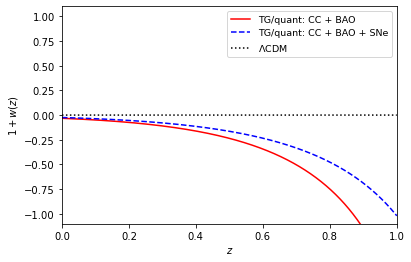

In [23]:
plot_best_fit_wz([gdsamples_0, gdsamples_1],
                 ['TG/quant: CC + BAO', 'TG/quant: CC + BAO + SNe'],
                 ['r-', 'b--'])

This shows that within this model, the quantum-corrections source a phantom-like dark energy permeating in the late Universe.

### Data references

**pantheon**

D. M. Scolnic et al., The Complete Light-curve Sample of Spectroscopically Confirmed SNe Ia
from Pan-STARRS1 and Cosmological Constraints from the Combined Pantheon Sample,
Astrophys. J. 859 (2018) 101 [[1710.00845](https://arxiv.org/abs/1710.00845)].

**cosmic chronometers**

M. Moresco, L. Pozzetti, A. Cimatti, R. Jimenez, C. Maraston, L. Verde et al., *A 6%
measurement of the Hubble parameter at z ∼ 0.45: direct evidence of the epoch of cosmic
re-acceleration*, JCAP 05 (2016) 014 [1601.01701](https://arxiv.org/abs/1601.01701).

M. Moresco, *Raising the bar: new constraints on the Hubble parameter with cosmic
chronometers at z ∼ 2*, Mon. Not. Roy. Astron. Soc. 450 (2015) L16 [1503.01116](https://arxiv.org/abs/1503.01116).

C. Zhang, H. Zhang, S. Yuan, S. Liu, T.-J. Zhang and Y.-C. Sun, *Four new observational H(z)
data from luminous red galaxies in the Sloan Digital Sky Survey data release seven*, Research in
Astronomy and Astrophysics 14 (2014) 1221 [1207.4541](https://arxiv.org/abs/1207.4541).

D. Stern, R. Jimenez, L. Verde, M. Kamionkowski and S. A. Stanford, *Cosmic chronometers:
constraining the equation of state of dark energy. I: H(z) measurements*, JCAP 2010 (2010)
008 [0907.3149](https://arxiv.org/abs/0907.3149).

M. Moresco et al., *Improved constraints on the expansion rate of the Universe up to z$\sim$1.1 from
the spectroscopic evolution of cosmic chronometers*, JCAP 2012 (2012) 006 [1201.3609](https://arxiv.org/abs/1201.3609).

A. L. Ratsimbazafy, S. I. Loubser, S. M. Crawford, C. M. Cress, B. A. Bassett, R. C. Nichol
et al., *Age-dating Luminous Red Galaxies observed with the Southern African Large Telescope*,
Mon. Not. Roy. Astron. Soc. 467 (2017) 3239 [1702.00418](https://arxiv.org/abs/1702.00418).

**baryon acoustic oscillations**

C. Blake, S. Brough, M. Colless, C. Contreras, W. Couch, S. Croom et al., *The WiggleZ Dark
Energy Survey: joint measurements of the expansion and growth history at z $<$ 1*, Mon. Not.
Roy. Astron. Soc. 425 (2012) 405 [1204.3674](https://arxiv.org/abs/1204.3674).

C.-H. Chuang et al., *The clustering of galaxies in the SDSS-III Baryon Oscillation
Spectroscopic Survey: single-probe measurements and the strong power of normalized growth
rate on constraining dark energy*, Mon. Not. Roy. Astron. Soc. 433 (2013) 3559 [1303.4486](https://arxiv.org/abs/1303.4486).

BOSS collaboration, *Quasar-Lyman α Forest Cross-Correlation from BOSS DR11 : Baryon
Acoustic Oscillations*, JCAP 05 (2014) 027 [1311.1767](https://arxiv.org/abs/1311.1767).

BOSS collaboration, *Baryon acoustic oscillations in the Lyα forest of BOSS DR11 quasars*,
Astron. Astrophys. 574 (2015) A59 [1404.1801](https://arxiv.org/abs/1404.1801).

J. E. Bautista et al., *Measurement of baryon acoustic oscillation correlations at z = 2.3 with
SDSS DR12 Lyα-Forests*, Astron. Astrophys. 603 (2017) A12 [1702.00176](https://arxiv.org/abs/1702.00176).

**python packages**

``cobaya``: J. Torrado and A. Lewis, Cobaya: Code for Bayesian Analysis of hierarchical physical models (2020) [[2005.05290](https://arxiv.org/abs/2005.05290)].

``getdist``: A. Lewis, GetDist: a Python package for analysing Monte Carlo samples (2019) [[1910.13970](https://arxiv.org/abs/1910.13970)].

``numpy``: C. R. Harris et al., Array programming with NumPy, [Nature 585 (2020) 357–362](https://www.nature.com/articles/s41586-020-2649-2?fbclid=IwAR3qKNC7soKsJlgbF2YCeYQl90umdrcbM6hw8vnpaVvqQiaMdTeL2GZxUR0).

``scipy``: P. Virtanen et al., SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python,
[Nature Methods 17 (2020) 261](https://www.nature.com/articles/s41592-019-0686-2).

``matplotlib``: J. D. Hunter, Matplotlib: A 2d graphics environment, [Computing in Science Engineering 9
(2007) 90](https://ieeexplore.ieee.org/document/4160265).